# Port Seguro Insurance Claim Prediction
This is my attempt at the Porto Seguro Safe Driver Kaggle competition. It is my first attempt at a Kaggle competition and I am super excited to finally be putting my data science skills to the test. I chose this competition because I find it an interesting application of machine learning. The objective is to predict whether or not a driver will have an insurance claim. The data is masked, meaning we don't really know what any of it means.

https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

I start by loading in the data and getting a broad overview of the data set. 

In [7]:
import numpy as np
import pandas as pd

df = pd.read_csv('train.csv')

In [8]:
print(df.shape)
print(list(df.dtypes))
print(df.isnull().sum())
df.head()

(595212, 59)
[dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64')]
id                0
ta

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


We see there are ~600k data points with 59 columns:
    - 1 index
    - 1 target (claim or no claim) 
    - 57 numerical features.

It looks like they are all numerical (either *int*s or *float*s) meaning we don't seem to have any text related data. Because the data is in such a nice format, I am going to dive right into seeing what kind of results we can get with a few untrained models. This will give a baseline for how good we can do without doing any hyperparameter tuning or feature engineering. Before we do that though, we need to one-hot encode the categorical variables. 

In [76]:
from sklearn.preprocessing import OneHotEncoder

def onehotcatcols(x,uniquevalthresh = 10):
    """
    Takes feature data, x, and one hot encodes only the columns
    that have less then 10 and more than 2 columns. Then joins
    that data back up with the other features. 
    
    Input x must be numerical data, but can be negative.
    """
    orig = x.shape
    catcols = []
    noncatcols = []
    colnum = 0
    minval = 0 

    # If any column has between 3 and uniquevalthresh unique values, 
    # consider it categorical and add it to the catcols data
    for col in list(x):
        if (len(x[col].unique()) < uniquevalthresh and len(x[col].unique()) > 2): 
            catcols.append(colnum)
            if min(x[col]) < minval:
                minval = min(x[col])
        else: 
            noncatcols.append(colnum)
        colnum += 1
        
    catdata = x.iloc[:,catcols] - minval
    noncatdata = x.iloc[:,noncatcols]

    enc = OneHotEncoder()
    catdata = enc.fit_transform(catdata)
    catdata = pd.DataFrame(catdata.toarray())
    
    # Join categorical and non-categorical data back together and return it
    newx = pd.concat([catdata, noncatdata], axis = 1, join='inner')
    print ("Converted shape of %s to %s!") % (orig, newx.shape)
    return newx

features = df.drop(['target', 'id'], axis = 1)

x = onehotcatcols(features)
y = df['target']

print(x.shape)
print(y.shape)

Converted shape of (595212, 57) to (595212, 118)!
(595212, 118)
(595212L,)


We went from having 57 features to 118 features from one-hot encoding, meaning at this point we have a pretty massive data set (600k rows and 118 features). Most models require (or at minimum, produce improved results with) 0-1 feature scaling of input data, so I am going to scale the features just for simplicity sake. 

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x))
x.shape

(595212, 118)

Now that the data is ready, we can do an 80-20 test train split. I am going to use stratified sampling to ensure we get a consistent percent of accidents (target=1) in our train and test data. 

In [78]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = .2, stratify = y, random_state = 123)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(476169, 118)
(476169L,)
(119043, 118)
(119043L,)


Now that the data is ready, I will make a custom scorer for normalized gini coefficient. SciKit Learn does not offer this as a function and this is what Kaggle is using as a scoring metric. 

In [12]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
     assert( len(actual) == len(pred) )
     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
     totalLosses = all[:,0].sum()
     giniSum = all[:,0].cumsum().sum() / totalLosses
 
     giniSum -= (len(actual) + 1) / 2.
     return giniSum / len(actual)
 
def gini_normalized(a, p):
     return gini(a, p) / gini(a, a)
    
from sklearn.metrics import make_scorer

norm_gini = make_scorer(gini_normalized, needs_proba = True)

Now that the data is ready to go and we have a scoring function, we'll test out a couple common different models. Below I briefly mention the models I will test, why I chose them, and some hyperparameters that I am tweaking right off the bat. 

- **Random Forest**
    - **Why**: 
        - Random forests are known for performing well in many machine learning projects, though their run times do not scale well with large data sets and thus run-time may be an issue. 
    - **Hyperparameters**:
        - SciKit Learn's implementation starts with *n_estimators* (# of trees) as 10, but I am going to change this to 100 since we have such a massive data set. 
        - I'll also set *max_depth* as 20 in hopes that it will reduce overfitting. 
        - I am also setting the *n_jobs* parameter to -1 in order to take advantage of my dual-core processor considering runtime may be slow on this rather large data set. 


- **Logistic Regression**
    - **Why**: 
        - Logistic regression is designed in order to predict the probability that an event will occur. 
        - Time complexity scales well with large data sets, though it often misses complex relationships. 
    - **Hyperparameters**:
        - Since we have a highly skewed data set (only 5% of people actually file a claim in this data set), we should set class weights to 'balance'. This will ensure we aren't just always guessing 'no claim'! 

- **Stochastic Gradient Descent Classifier**
    - **Why**: 
        - Logistic regression is designed in order to predict the probability that an event will occur. The time complexity scales well with large data sets, though often misses complex relationships. 
    - **Hyperparameters**:
        - I can set loss function to 'log' to solve a logistic regression problem using stochastic gradient descent
        - I need to use balanced class weights here for the same reason as above. 

I also set the random seed arbitrarily to 123 to ensure reproducability. 

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators = 50, random_state = 123, class_weight = 'balanced')
rf.fit(train_x, train_y)
preds = rf.predict_proba(test_x) 

print("random forest scores: %s" %(gini_normalized(test_y,preds)))

random forest scores: -0.124948145538


In [45]:
rf = RandomForestClassifier(n_estimators = 50, random_state = 123)
rf.fit(train_x, train_y)
preds = rf.predict_proba(test_x) 

print("random forest scores: %s" %(gini_normalized(test_y,preds)))

random forest scores: -0.152731219225


In [80]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight = 'balanced', random_state = 123)
logreg_scores = cross_val_score(logreg, train_x, train_y, scoring = 'roc_auc', cv=5)

print("logistic regression scores: %s" %(logreg_scores))

logistic regression scores: [ 0.6203623   0.63291688  0.62634287  0.62964187  0.62954621]


In [14]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', class_weight = norm_gini, random_state = 123)
sgd_scores = cross_val_score(sgd, train_x, train_y, scoring = 'roc_auc', cv=5)

print("stochastic gradient descent scores: %s" %(sgd_scores))

C:\Users\Vicky\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


stochastic gradient descent scores: [ 0.55084491  0.52197164  0.52467192  0.51720258  0.52012382]


Now that we can see a basic model isn't overfitting the data, we can compute the normalized gini coefficient using our models. Kaggle was nice enough to offer the code to compute a normalized gini coefficent, which is the metric our submissiong will be based upon.  

In [18]:
rf.fit(train_x, train_y)
rf_preds = rf.predict(test_x)
print(gini_normalized(test_y, rf_preds))

logreg.fit(train_x, train_y)
logreg_preds = logreg.predict(test_x)
print(gini_normalized(test_y, logreg_preds))

sgd.fit(train_x, train_y)
sgd_preds = sgd.predict(test_x)
print(gini_normalized(test_y, sgd_preds))


0.0164782803208
0.189036222608
0.0928555195566


It looks like the logistic regression performed the best by far. Let's check out a confusion matrix to see how we did!

In [87]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = [0,1]
cnf_matrix = confusion_matrix(test_y, logreg_preds)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Ins. Claims Confusion matrix')

plt.show()

NameError: name 'logreg_preds' is not defined

It looks like we would have predicted 2477 out of 4458 claims correctly, though we had 43k false positives *(smh)*. Not bad, considering we haven't really done anything! Now we'll just re-train the logistic regression model on the entire data set, use it to predict the test.7z file and save the output in the correct format in a file called *results.csv*, which can then be uploaded into the Kaggle submissions page.

In [21]:
logreg.fit(x,y)
testdata = pd.read_csv('test.csv')

test_features = testdata.drop(['id'], axis = 1)
test_x = onehotcatcols(test_features)

out = logreg.predict_proba(test_x)
out = pd.DataFrame(out[:,1])
out = pd.concat([testdata['id'], out], axis = 1, join = 'inner')
out.columns = ['id', 'target']

out.to_csv('kaggle_submission.csv', index = False)

Converted shape of (892816, 57) to (892816, 118)!


After submitting to Kaggle, I scored .25 which got me 3659 out of 4729 (roughly 23rd percentile). Now that we have completed the project once and a baseline accuracy, let's do some real data science now. 

Unfortunately, Porto Seguro isn't telling us what any of this data actually means (presumably they don't want competitors taking the insight they're paying for), so we have no way of knowing what the data actually means. Due to this masking, **we'll have to blindly look for relationships in the data**. 

We can see right away that the columns have a particular nomenclature.  
1. They all start with *ps* (presumably standing for Porto Seguro), 
2. They either have a *ind, reg, car, or calc* after them. 
    * Columns ending in *bin* and *cat* seem to be integer based, so those probably stand for in binary and categorical.
    * Columns ending in *calc* are probably calculated columns and may exhibit more complex interactions
3. *ind* stands for individual characteristics while *car* stands for vehicle characteristics

Let's check out a correlation matrix to see some general trends in variables

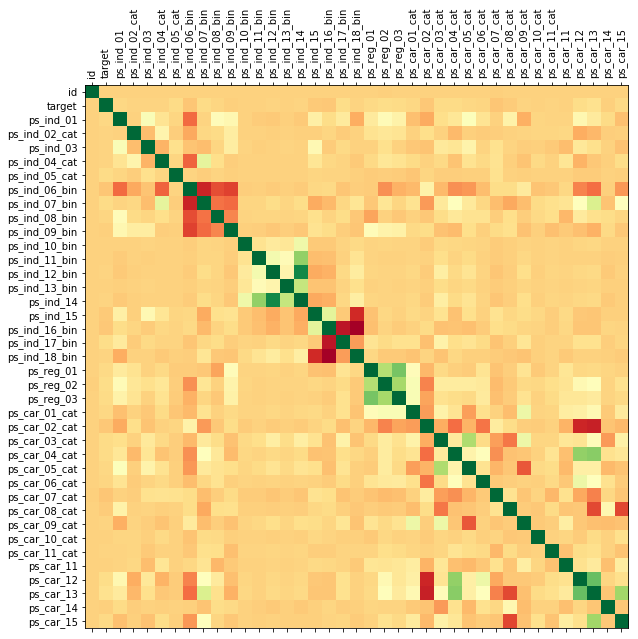

In [144]:
dfc = df[list(col for col in list(df) if "calc" not in col)]
corr = dfc.corr()
df.values[[np.arange(len(list(df)))]*2] = 0
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.set_cmap('RdYlGn')
plt.show()

From this we can see a few things:
1. No variables appear to have any correlation with the target, which could be why we got such poor results from our initial models and is probably typical of complex anomaly problems such as this
2. *ind_06* to *ind_09* are highly anti-correlated
3. *ind_14* is highly correlated with *ind_11_bin, ind_12_bin,* and *ind_13_bin*
4. *ind_16_bin, ind_17_bin,* and *ind_18_bin* are anti-correlated
5. *car_12* and *car_13* are anti-correlated with *car_02_cat* and correlated with *car_04_cat*

0

With the number of features being so high, one thing we should consider is dimensionality reduction. Running a quick Principle Components Analysis (PCA) below doesn't work great, but allows us to reduce the number of components from 118 to 88 with only losing ~ 4% of the variance. Not a bad tradeoff considering we reduce the number of components by 25%.

In [180]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 88 )
reddim = pca.fit_transform(x)

print('Old column count:     ' + str(len(x.columns)))
print('New column count:     ' + str(pca.n_components))
print('% of columns removed: ' + str(round(1-float(pca.n_components)/len(x.columns),3)*100) + '%')
print('% variance retained:  ' + str(round(sum(pca.explained_variance_ratio_),3)*100) + '%')


Old column count:     118
New column count:     88
% of columns removed: 25.4%
% variance retained:  95.9%


In [88]:
confusion_matrix(df['ps_ind_09_bin'],df['ps_ind_08_bin'])

array([[387349,  97568],
       [110295,      0]], dtype=int64)